In [1]:
# Pre-Processing
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
import gensim
from nltk.stem import PorterStemmer

# Modeling
import statsmodels.api as sm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.util import ngrams
from collections import Counter
from gensim.models import word2vec
from nltk.tokenize import word_tokenize
from gensim import corpora, models, similarities
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer

# For the first-time user, you should download these two pre-trained tokenizer
#nltk.download('punkt') 
#nltk.download('stopwords')

import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv',index_col = 0)
sentiment_label = df["Recommended IND"]
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [3]:
df['Class Name'].unique()

array(['Intimates', 'Dresses', 'Pants', 'Blouses', 'Knits', 'Outerwear',
       'Lounge', 'Sweaters', 'Skirts', 'Fine gauge', 'Sleep', 'Jackets',
       'Swim', 'Trend', 'Jeans', 'Legwear', 'Shorts', 'Layering',
       'Casual bottoms', nan, 'Chemises'], dtype=object)

In [4]:
df['Class Name'].nunique()

20

# 1. Data Pre-processing

In [3]:
# Pre-process
# choose review text
pdtextpreprocess = df[["Title","Review Text", "Rating"]]
pdtextpreprocess['index'] = pdtextpreprocess.index

documents = [str(m)+" "+str(n) for m,n in zip(pdtextpreprocess["Title"],pdtextpreprocess["Review Text"])] # add title as part of review text

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [4]:
texts_tokenized = [[word.lower() for word in word_tokenize(str(document))] for document in documents]#text tokenized and transformed to lowercase

#Update stop words
stop_words = set(stopwords.words('english'))
stop_words.update(['nan','\'s','n\'t','\'\'','\'ve','\'m','1','2','3','4','5','6','7','8','9','0',"\'m","..."])

texts_filtered_stopwords = [[word for word in document if not word in stop_words] for document in texts_tokenized]#move stop_words

# puncuations
english_punctuations = list(string.punctuation)
texts_filtered = [[word for word in document if not word in english_punctuations] for document in texts_filtered_stopwords]#move english_punctuations

#Bigram for words that frequently appear together
#bigram = gensim.models.Phrases(texts_tokenized)
#texts_filtered_bigram = [bigram[line] for line in texts_filtered]

stemmer = PorterStemmer()
#stemmer =LancasterStemmer()
texts_stemmed = [[stemmer.stem(word) for word in docment] for docment in texts_filtered]

all_stems = sum(texts_stemmed, [])
stems_once = set(stem for stem in set(all_stems) if all_stems.count(stem) == 1)
texts = [[stem for stem in text if stem not in stems_once] for text in texts_stemmed]

In [5]:
from gensim.corpora import Dictionary

dictionary = Dictionary(texts)  # fit dictionary
corpus = [dictionary.doc2bow(line) for line in texts]  # convert corpus to BoW format

tfidf = models.TfidfModel(corpus)#calculate tf-idf
corpus_tfidf = tfidf[corpus]#use tf-idfs to represent documents

# 2. Topic Modeling: LSA and LDA

## 2.1 LSA

In [39]:
#Use coherence values to determine the optimal number of topics for LSA
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

coherence_values_LSA = []
model_list_LSA = []
for num_topics in range(2,11):
    model = models.LsiModel(corpus_tfidf, num_topics=num_topics, id2word = dictionary) 
    model.show_topics()
    model_list_LSA.append(model)
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_values_LSA.append(coherencemodel.get_coherence())

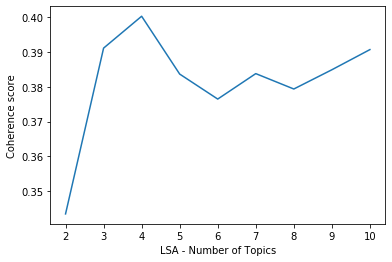

In [42]:
x = range(2,11)
plt.plot(x, coherence_values_LSA)
plt.xlabel("LSA - Number of Topics")
plt.ylabel("Coherence score")
plt.show()

In [43]:
print('The LSA model with ' + str(coherence_values_LSA.index(max(coherence_values_LSA))+2) + ' topics' 
      + ' has the highest average coherence value:\n'+ str(max(coherence_values_LSA)))

The LSA model with 4 topics has the highest average coherence value:
0.400329084644534


In [44]:
#Terms in each topic
model_list_LSA[coherence_values_LSA.index(max(coherence_values_LSA))].show_topics(num_topics = -1,formatted=False)

[(0,
  [('dress', 0.22087485328172504),
   ('top', 0.17518326724288727),
   ('love', 0.1559008678229154),
   ('size', 0.15572637912278683),
   ('great', 0.15149662038309972),
   ('fit', 0.1442042191732407),
   ('look', 0.13236033534960076),
   ('color', 0.1280937645104057),
   ('wear', 0.12462420287012717),
   ('like', 0.12048047258418305)]),
 (1,
  [('dress', 0.6415981481480318),
   ('shirt', -0.2626238952964523),
   ('jean', -0.24915398516476508),
   ('sweater', -0.20564193848424406),
   ('great', -0.174272740846597),
   ('top', -0.16457964479050266),
   ('soft', -0.1538602660246913),
   ('pant', -0.15260054403711884),
   ('beauti', 0.13592220486097856),
   ('cute', -0.1294662995941209)]),
 (2,
  [('dress', 0.43966274076041595),
   ('small', -0.22904658942756093),
   ('comfort', 0.21738204302025782),
   ('great', 0.21263157994571302),
   ('top', -0.20770518465374546),
   ('perfect', 0.18416467548960294),
   ('larg', -0.17835877767269137),
   ('run', -0.17309975182505163),
   ('jean',

## 2.2 LDA

In [8]:
#Use coherence values to determine the optimal number of topic for LDA
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

coherence_values_LDA = []
model_list_LDA = []
for num_topics in range(2,11,1):
    model = models.LdaModel(corpus_tfidf, num_topics=num_topics, id2word = dictionary) 
    model.show_topics()
    model_list_LDA.append(model)
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_values_LDA.append(coherencemodel.get_coherence())

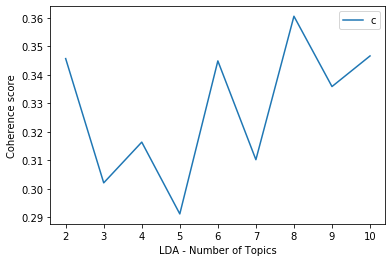

In [9]:
x = range(2,11,1)
plt.plot(x, coherence_values_LDA)
plt.xlabel("LDA - Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [10]:
print('The LDA model with ' + str(coherence_values_LDA.index(max(coherence_values_LDA))+2) + ' topics' 
      + ' has the highest average coherence value:\n'+ str(max(coherence_values_LDA)))

The LDA model with 8 topics has the highest average coherence value:
0.3605385809235193


In [17]:
#Terms in each topic
model_list_LDA[coherence_values_LDA.index(max(coherence_values_LDA))].show_topics(num_topics = -1,formatted=False)

[(0,
  [('kimono', 0.013534954),
   ('date', 0.009464405),
   ('sparkl', 0.008152488),
   ('friday', 0.0062317923),
   ('flip', 0.005776014),
   ('leather', 0.005678626),
   ('correct', 0.0055933795),
   ('morn', 0.0053858464),
   ('flop', 0.0049258634),
   ('billow', 0.0049230335)]),
 (1,
  [('dress', 0.008294447),
   ('size', 0.0047924784),
   ('love', 0.004663554),
   ('like', 0.004372509),
   ('look', 0.0043386966),
   ('fabric', 0.0043154787),
   ('top', 0.0040905885),
   ('would', 0.0038503027),
   ('fit', 0.0038343014),
   ('beauti', 0.003814525)]),
 (2,
  [('dress', 0.008869396),
   ('top', 0.00674619),
   ('love', 0.0058919643),
   ('beauti', 0.005816857),
   ('color', 0.0056937905),
   ('look', 0.0052947626),
   ('size', 0.0052434076),
   ('fit', 0.005035753),
   ('like', 0.004816887),
   ('order', 0.004757615)]),
 (3,
  [('great', 0.012224244),
   ('love', 0.010323437),
   ('dress', 0.009980874),
   ('comfort', 0.008940898),
   ('sweater', 0.00852795),
   ('perfect', 0.00829

## 2.2.1 LDA - Topic Distribution

In [11]:
#Select the highest probaility of topic for each documents in the best LDA model
def doc_topic(corpus):
    corpus_transformed = model_list_LDA[coherence_values_LDA.index(max(coherence_values_LDA))][corpus]
    topic_det = []
    for i in range(len(corpus)):
        topic_pro = []
        for (topic_id, topic_probability) in corpus_transformed[i]:
            topic_pro.append(topic_probability)
        topic_det.append(topic_pro.index(max(topic_pro)))
    return topic_det

In [12]:
topic_det = doc_topic(corpus_tfidf)

In [13]:
x = list('Topic'+ str(i) for i in range(coherence_values_LDA.index(max(coherence_values_LDA))+2))
y = []
for i in range(coherence_values_LDA.index(max(coherence_values_LDA))+2):
    y.append(topic_det.count(i))

Text(0.5, 1.0, 'LDA model - Topic Distribution in Documents')

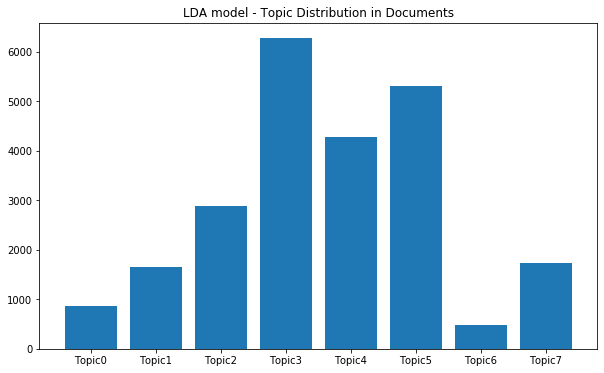

In [14]:
plt.figure(figsize = (10,6))
plt.bar(x,y)
plt.title('LDA model - Topic Distribution in Documents')

## 2.2.2 LDA - Visualization

In [15]:
#Visualize LDA result
import pyLDAvis
from pyLDAvis import gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(model_list_LDA[coherence_values_LDA.index(max(coherence_values_LDA))], corpus, dictionary)

/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.087748 -0.070461       1        1  29.573376
4      0.056006  0.019031       2        1  21.599358
5      0.062305 -0.015513       3        1  19.156124
2      0.040336 -0.001282       4        1  11.799286
7      0.034388 -0.005886       5        1   8.263495
1      0.021891 -0.009211       6        1   5.830309
6     -0.062236  0.149116       7        1   2.769038
0     -0.240438 -0.065795       8        1   1.009021, topic_info=     Category         Freq    Term        Total  loglift  logprob
8     Default  5577.000000   dress  5577.000000  30.0000  30.0000
57    Default  3861.000000    size  3861.000000  29.0000  29.0000
210   Default  3160.000000  beauti  3160.000000  28.0000  28.0000
58    Default  2969.000000   small  2969.000000  27.0000  27.0000
1118  Default   455.000000    suit   455.000000  26.0000  26.0000
...       ...          ...     ...          ...      ...      ...
1021   Topic8    24.958658     fat    62.794662   3.6735  -5.6285
5      Topic8    24.202372      bc    54.981899   3.7756  -5.6592
1333   Topic8    26.234825   smell   141.675140   2.9097  -5.5786
8      Topic8    24.718918   dress  5577.154297  -0.8227  -5.6381
2531   Topic8    21.509823   spare    43.410034   3.8940  -5.7772

[629 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1851      1  0.044214   .the
1851      2  0.044214   .the
1851      3  0.044214   .the
1851      4  0.044214   .the
1851      5  0.044214   .the
...     ...       ...    ...
4465      1  0.945355  yummi
4465      2  0.011671  yummi
4465      3  0.011671  yummi
4465      4  0.011671  yummi
4465      5  0.011671  yummi

[3028 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 6, 3, 8, 2, 7, 1])

## 2.2.3 LDA - Topics with the Highest Coherence Values

In [8]:
#Try LDA model with 50 topics and sort with topic coherence values
import operator
lm = models.LdaModel(corpus=corpus_tfidf, id2word=dictionary,num_topics=50)
coherence_values = {}
for n, topic in lm.show_topics(num_topics=-1, formatted=False):
    topic = [word for word, _ in topic]
    cm = CoherenceModel(topics=[topic], texts=texts, dictionary=dictionary, window_size=10)
    coherence_values[n] = cm.get_coherence()
top_topics = sorted(coherence_values.items(), key=operator.itemgetter(1), reverse=True)
top_topics

[(43, 0.684633988874414),
 (35, 0.6726805408636543),
 (19, 0.6680617309660835),
 (42, 0.6473408661620652),
 (11, 0.6458906174520951),
 (29, 0.6453397986969007),
 (17, 0.6427012669261022),
 (23, 0.6423462308229683),
 (38, 0.641370510739024),
 (47, 0.625716628716807),
 (40, 0.6238610922667217),
 (10, 0.6168076152033785),
 (49, 0.6153194213411755),
 (7, 0.6144185889718512),
 (41, 0.6101785284230978),
 (2, 0.6061974108463453),
 (33, 0.5978131914014664),
 (44, 0.5951733008232372),
 (1, 0.5770889907255193),
 (13, 0.5611066046037446),
 (4, 0.5493069985654895),
 (5, 0.5025335178469239),
 (16, 0.49152451668666985),
 (6, 0.4847720025109358),
 (21, 0.4720101090781631),
 (32, 0.4292917837809963),
 (34, 0.42137759360860916),
 (36, 0.4172982584918108),
 (8, 0.39365797911413497),
 (48, 0.38539531525512444),
 (28, 0.3673429917492125),
 (39, 0.36657944187267294),
 (18, 0.36455269577298366),
 (20, 0.36411953453486057),
 (9, 0.34982907574727873),
 (27, 0.3311642688855412),
 (22, 0.32146151397916956),
 (3

In [9]:
#Print top 10 topics with the highest coherence values
from pprint import pprint
pprint([lm.show_topic(topicid) for topicid, c_v in top_topics[:10]])

[[('sock', 0.026755236),
  ('con', 0.023265613),
  ('strang', 0.02317087),
  ('flirti', 0.02082289),
  ('34b', 0.01959626),
  ('embroid', 0.019552818),
  ('thru', 0.019358192),
  ('fenc', 0.01822331),
  ('boyfriend', 0.018169709),
  ('nearli', 0.017373573)],
 [('jumpsuit', 0.050781414),
  ('aw', 0.022530057),
  ('winner', 0.019753281),
  ('25', 0.018181834),
  ('art', 0.017028684),
  ('understand', 0.016902765),
  ('rare', 0.016030667),
  ('vacat', 0.01599642),
  ('past', 0.015804866),
  ('enjoy', 0.014991512)],
 [('rise', 0.03918688),
  ('pop', 0.033281628),
  ('volum', 0.025640605),
  ('happen', 0.024763597),
  ('rayon', 0.02307251),
  ('warmer', 0.021900047),
  ('readi', 0.021165749),
  ('tini', 0.020469183),
  ('140', 0.017869562),
  ('fashion', 0.017712254)],
 [('cross', 0.022746375),
  ('xsp', 0.020982275),
  ('s.', 0.018521056),
  ('occas', 0.017141264),
  ('pleas', 0.01519738),
  ('featur', 0.013631289),
  ('beyond', 0.013505822),
  ('polish', 0.013472906),
  ('pj', 0.013097635

# 3. Predict Sentiment & Prediction Error

(Recommended / Not recommended) of reviews using their bag-of-topics features by fitting a logistic regression model.

## 3.1 LSA

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score  

In [50]:
#Initialize the regressor
lr = LogisticRegression(solver='liblinear')

In [63]:
#Fit logistic regression to the best LSA model from Part 2.1 

X=[]
y=[]

LSA = model_list_LSA[coherence_values_LSA.index(max(coherence_values_LSA))]
topic_singular_vector = LSA[corpus_tfidf]
s_5 = pd.Series(topic_singular_vector)
tmp = pd.DataFrame(s_5, columns=['data'])
LSA_bag_of_topics = pd.DataFrame(list(map(dict, tmp['data'])))
LSA_bag_of_topics.dropna(inplace = True)
X.append(LSA_bag_of_topics.values)  
y.append(sentiment_label[LSA_bag_of_topics.index].values)

In [79]:
lr.fit(X[0],y[0])
predicted = lr.predict(X[0])
score = accuracy_score(predicted, y[0])
print('LSA num_topics of ' + str(model_list_LSA.index(model_list_LSA[coherence_values_LSA.index(max(coherence_values_LSA))])+2))
print("Prediction accuracy = " , score)
print("Prediction error = {0:.3%}".format(1-score))

LSA num_topics of 4
Prediction accuracy =  0.8176397844713365
Prediction error = 18.236%


## 3.2 LDA

In [18]:
#Fit logistic regression to the best LDA model from Part 2.2 

def bag_of_topic(corpus,model):
    corpus_transformed = model.get_document_topics(corpus)
    topic_det = pd.DataFrame(index = range(len(corpus)),columns = range(model_list_LDA.index(model)+2))
    for i in range(len(corpus)):
        topic_pro = []
        for (topic_id, topic_probability) in corpus_transformed[i]:
            topic_pro.append(topic_probability)
        topic_det.iloc[i] = topic_pro
        
    x = topic_det.values
    y = sentiment_label.values  
    lr.fit(x, y)

    predicted = lr.predict(x)
    score = accuracy_score(predicted, y)
    
    print('LDA num_topics of ' + str(model_list_LDA.index(model)+2))
    print("Prediction accuracy = " , score)
    return score

In [80]:
accuracy_score=bag_of_topic(corpus_tfidf,model_list_LDA[coherence_values_LDA.index(max(coherence_values_LDA))])
print("Prediction error = {0:.3%}".format(1-accuracy_score))

LDA num_topics of 8
Prediction accuracy =  0.8223622583666865
Prediction error = 17.764%


## 4. Cross Validation to Select the Topic Number for LSA&LDA model

In [31]:
from sklearn.model_selection import cross_validate

## 4.1 LSA

In [51]:
#Fit LSA and append inputs&outputs for logistic regression
X=[]
y=[]
for i in range(2,11):
    LSA = model_list_LSA[i-2]
    topic_singular_vector = LSA[corpus_tfidf]
    s_5 = pd.Series(topic_singular_vector)
    tmp = pd.DataFrame(s_5, columns=['data'])
    LSA_bag_of_topics = pd.DataFrame(list(map(dict, tmp['data'])))
    LSA_bag_of_topics.dropna(inplace = True)
    X.append(LSA_bag_of_topics.values)  
    y.append(sentiment_label[LSA_bag_of_topics.index].values)

In [53]:
#Accuracy scores for LSA models(cross validation)
cv_LSA_scores=[]
for i in range(len(X)):
    cv_results = cross_validate(lr, X[i], y[i],cv=5)
    average = sum(cv_results['test_score'])/5
    cv_LSA_scores.append(average)
    print('LSA num_topics of ' + str(i+2))
    print("Prediction accuracy = " , average)

LSA num_topics of 2
Prediction accuracy =  0.8188764342935592
LSA num_topics of 3
Prediction accuracy =  0.8177279463958378
LSA num_topics of 4
Prediction accuracy =  0.8179046443419995
LSA num_topics of 5
Prediction accuracy =  0.8334071053596362
LSA num_topics of 6
Prediction accuracy =  0.8457734849725818
LSA num_topics of 7
Prediction accuracy =  0.8467012613202913
LSA num_topics of 8
Prediction accuracy =  0.8490420167083986
LSA num_topics of 9
Prediction accuracy =  0.8514268247022206
LSA num_topics of 10
Prediction accuracy =  0.8508526002542922


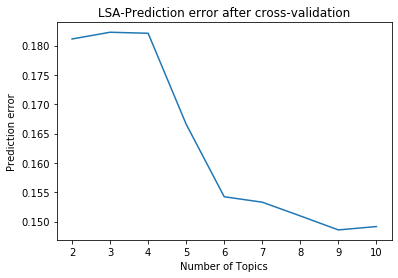

In [54]:
cv_LSA_error = [1 - i for i in cv_LSA_scores]
rg = range(2,11,1)
plt.plot(rg,cv_LSA_error)
plt.title("LSA-Prediction error after cross-validation")
plt.xlabel("Number of Topics")
plt.ylabel("Prediction error")
plt.show()

In [56]:
print('The LSA model with ' + str(cv_LSA_scores.index(max(cv_LSA_scores))+2) + ' topics' 
      + ' has the highest cross validation accuracy score:\n'+ str(max(cv_LSA_scores)))

The LSA model with 9 topics has the highest cross validation accuracy score:
0.8514268247022206


## 4.2 LDA

In [34]:
#Calculate the prediction accuracy based on LDA models after 5-fold cross validation
def cv_bag_of_topic(corpus,model):
    corpus_transformed = model.get_document_topics(corpus)
    topic_det = pd.DataFrame(index = range(len(corpus)),columns = range(model_list_LDA.index(model)+2))
    lr = LogisticRegression(solver='liblinear')
    for i in range(len(corpus)):
        topic_pro = []
        for (topic_id, topic_probability) in corpus_transformed[i]:
            topic_pro.append(topic_probability)
        topic_det.iloc[i] = topic_pro
        
    x = topic_det.values
    y = sentiment_label.values
    cv_results = cross_validate(lr, x, y, cv=5)

    score = sum(cv_results['test_score'])/5
    
    print('LDA num_topics of ' + str(model_list_LDA.index(model)+2))
    print("Prediction accuracy = " , score)
    return score

In [35]:
#Accuracy scores for LDA models(cross validation)
cv_LDA_scores = list(range(2,11))
for i in range(2,11):
    cv_LDA_scores[i-2] = cv_bag_of_topic(corpus_tfidf,model_list_LDA[i-2])

LDA num_topics of 2
Prediction accuracy =  0.8223622683609637
LDA num_topics of 3
Prediction accuracy =  0.8223622502300835
LDA num_topics of 4
Prediction accuracy =  0.8132506762049033
LDA num_topics of 5
Prediction accuracy =  0.8223622683609637
LDA num_topics of 6
Prediction accuracy =  0.8223622683609637
LDA num_topics of 7
Prediction accuracy =  0.8223622683609637
LDA num_topics of 8
Prediction accuracy =  0.8223622683609637
LDA num_topics of 9
Prediction accuracy =  0.823809982860098
LDA num_topics of 10
Prediction accuracy =  0.8195096644980986


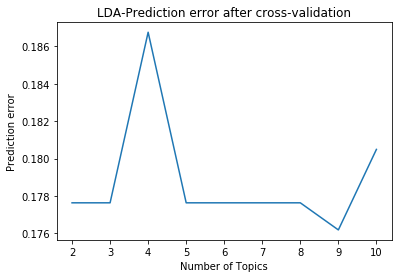

In [37]:
cv_LDA_error = [1 - i for i in cv_LDA_scores]
rg = range(2,11,1)
plt.plot(rg,cv_LDA_error)
plt.title("LDA-Prediction error after cross-validation")
plt.xlabel("Number of Topics")
plt.ylabel("Prediction error")
plt.show()

In [38]:
print('The LDA model with ' + str(cv_LDA_scores.index(max(cv_LDA_scores))+2) + ' topics' 
      + ' has the highest cross validation accuracy score:\n'+ str(max(cv_LDA_scores)))

The LDA model with 9 topics has the highest cross validation accuracy score:
0.823809982860098
